In [78]:
import pickle
import os
import numpy as np
import tensorflow as tf
import time
import random

from IPython.display import clear_output
from itertools import count

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

# Data loading

In [67]:
def convert_to_onehot(labels):
    res = np.zeros((labels.shape[0], labels.max() + 1), dtype=np.float32)
    res[range(labels.shape[0]), labels] = 1.
    return res

def read_cifar(path):
    train_data = np.empty((50000,3072), dtype=np.float32)
    train_labels = np.empty((50000,), dtype=np.int32)

    def shape_insanity(x):
        return x.reshape(x.shape[0], 3, 32, 32).swapaxes(1,3).swapaxes(1,2)
    
    
    for i in range(1, 6):
        with open(os.path.join(path, 'data_batch_%d' % (i,)), 'rb') as f:
            loaded = pickle.load(f, encoding='bytes')
            train_data[(i-1)*10000:i*10000,:] = loaded[b'data']
            train_labels[(i-1)*10000:i*10000] = loaded[b'labels']

    with open(os.path.join(path, 'test_batch'), 'rb') as f:
        loaded = pickle.load(f, encoding='bytes')
        test_data, test_labels = loaded[b'data'], loaded[b'labels']
        test_labels = np.array(test_labels, dtype=np.int32)

    return (
        shape_insanity(train_data) / 255.,
        convert_to_onehot(train_labels),
        shape_insanity(test_data) / 255.,
        convert_to_onehot(test_labels),
    )

def read_cifar100(filename):
    with open(filename, 'rb') as f:
        d = pickle.load(f, encoding="bytes")
        data = d[b'data'].astype(np.float32) / 255.
        labels = np.array(d[b'fine_labels'], dtype=np.int32)
        labels =convert_to_onehot(labels)
        return data, labels

def show_image(img):
    from PIL import Image
    i = Image.fromarray((img * 255.).astype(np.uint8))
    return i.resize((512,512),Image.BICUBIC)

def all_photos_from_category(category):
    return train_data[train_labels[:, category] == 1]

cifar10_classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [6]:
train_data, train_labels, test_data, test_labels = read_cifar('/home/sidor/datasets/cifar10/')

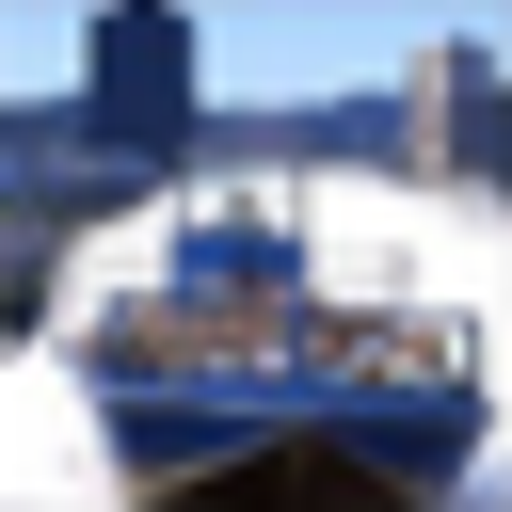

In [66]:
all_birds = all_photos_from_category(cifar10_classes.index("ship"))
show_image(all_birds[66])

In [39]:
import math
import tensorflow as tf

def base_name(var):
    """Extracts value passed to name= when creating a variable"""
    return var.name.split('/')[-1].split(':')[0]

class Layer(object):
    def __init__(self, input_sizes, output_size, scope):
        """Cretes a neural network layer."""
        if type(input_sizes) != list:
            input_sizes = [input_sizes]

        self.input_sizes = input_sizes
        self.output_size = output_size
        self.scope       = scope or "Layer"

        with tf.variable_scope(self.scope):
            self.Ws = []
            for input_idx, input_size in enumerate(input_sizes):
                W_name = "W_%d" % (input_idx,)
                W_initializer =  tf.random_uniform_initializer(
                        -1.0 / math.sqrt(input_size), 1.0 / math.sqrt(input_size))
                W_var = tf.get_variable(W_name, (input_size, output_size), initializer=W_initializer)
                self.Ws.append(W_var)
            self.b = tf.get_variable("b", (output_size,), initializer=tf.constant_initializer(0))

    def __call__(self, xs):
        if type(xs) != list:
            xs = [xs]
        assert len(xs) == len(self.Ws), \
                "Expected %d input vectors, got %d" % (len(self.Ws), len(xs))
        with tf.variable_scope(self.scope):
            return sum([tf.matmul(x, W) for x, W in zip(xs, self.Ws)]) + self.b

    def variables(self):
        return [self.b] + self.Ws

    def copy(self, scope=None):
        scope = scope or self.scope + "_copy"

        with tf.variable_scope(scope) as sc:
            for v in self.variables():
                tf.get_variable(base_name(v), v.get_shape(),
                        initializer=lambda x,dtype=tf.float32: v.initialized_value())
            sc.reuse_variables()
            return Layer(self.input_sizes, self.output_size, scope=sc)

class MLP(object):
    def __init__(self, input_sizes, hiddens, nonlinearities, scope=None, given_layers=None):
        self.input_sizes = input_sizes
        self.hiddens = hiddens
        self.input_nonlinearity, self.layer_nonlinearities = nonlinearities[0], nonlinearities[1:]
        self.scope = scope or "MLP"

        assert len(hiddens) == len(nonlinearities), \
                "Number of hiddens must be equal to number of nonlinearities"

        with tf.variable_scope(self.scope):
            if given_layers is not None:
                self.input_layer = given_layers[0]
                self.layers      = given_layers[1:]
            else:
                self.input_layer = Layer(input_sizes, hiddens[0], scope="input_layer")
                self.layers = []

                for l_idx, (h_from, h_to) in enumerate(zip(hiddens[:-1], hiddens[1:])):
                    self.layers.append(Layer(h_from, h_to, scope="hidden_layer_%d" % (l_idx,)))

    def __call__(self, xs):
        if type(xs) != list:
            xs = [xs]
        with tf.variable_scope(self.scope):
            hidden = self.input_nonlinearity(self.input_layer(xs))
            for layer, nonlinearity in zip(self.layers, self.layer_nonlinearities):
                hidden = nonlinearity(layer(hidden))
            return hidden

    def variables(self):
        res = self.input_layer.variables()
        for layer in self.layers:
            res.extend(layer.variables())
        return res

    def copy(self, scope=None):
        scope = scope or self.scope + "_copy"
        nonlinearities = [self.input_nonlinearity] + self.layer_nonlinearities
        given_layers = [self.input_layer.copy()] + [layer.copy() for layer in self.layers]
        return MLP(self.input_sizes, self.hiddens, nonlinearities, scope=scope,
                given_layers=given_layers)

class ConvLayer(object):
    def __init__(self, filter_H, filter_W, in_C, out_C, nonlinearity=tf.nn.relu, stride=(1,1), scope="Convolution"):
        self.stride       = stride
        self.nonlinearity = nonlinearity
        self.scope        = scope

        with tf.variable_scope(self.scope):
            input_size = filter_H * filter_W * in_C
            W_initializer =  tf.random_uniform_initializer(
                        -1.0 / math.sqrt(input_size), 1.0 / math.sqrt(input_size))
            self.W = tf.get_variable('W', (filter_H, filter_W, in_C, out_C), initializer=W_initializer)
            self.b = tf.get_variable('b', (out_C), initializer=tf.constant_initializer(0))
    
    def __call__(self, X):
        with tf.variable_scope(self.scope):
            return self.nonlinearity(tf.nn.conv2d(X, self.W,  strides=[1] + list(self.stride) + [1], padding='SAME') + self.b)
        
class DeconvLayer(object):
    def __init__(self, filter_H, filter_W, in_C, out_C, nonlinearity=tf.nn.relu,stride=(1,1), scope="Convolution"):
        self.nonlinearity = nonlinearity
        self.stride       = stride
        self.scope        = scope

        with tf.variable_scope(self.scope):
            input_size = filter_H * filter_W * in_C
            W_initializer =  tf.random_uniform_initializer(
                        -1.0 / math.sqrt(input_size), 1.0 / math.sqrt(input_size))
            self.W = tf.get_variable('W', (filter_H, filter_W, out_C, in_C), initializer=W_initializer)
            self.b = tf.get_variable('b', (out_C), initializer=tf.constant_initializer(0))
    
    def __call__(self, X):
        with tf.variable_scope(self.scope):
            in_shape    = X.get_shape().as_list()
            out_filters = self.W.get_shape().as_list()[2]
            out_shape   = [in_shape[0], self.stride[0] * in_shape[1], self.stride[1] * in_shape[2], out_filters]
            out_shape = tf.TensorShape(out_shape)
            strides     = [1] + list(self.stride) + [1]
            return self.nonlinearity(tf.nn.deconv2d(X, self.W, out_shape, strides, 'SAME') + self.b)
        


In [82]:
tf.ops.reset_default_graph()
if 'session' in globals():
    session.close()
session = tf.InteractiveSession()


GENERATOR_SEED = 100
def generator(in_seed, reuse=False):
    with tf.variable_scope("generator", reuse=reuse):
        g1 = Layer(GENERATOR_SEED, 1024 * 4 * 4, scope="project1")(in_seed)
        g1 = tf.reshape(tf.nn.relu(g1), (-1, 4, 4, 1024))
        # (BATCH, 4, 4, 1024)
        g2 = DeconvLayer(2, 2, 1024, 512, stride=(2,2), scope="dconv1")(g1)
        # (BATCH, 8, 8, 512)
        g3 = DeconvLayer(2, 2, 512, 256, stride=(2,2),  scope="dconv2")(g2)
        # (BATCH, 16, 16, 256)
        g4 = DeconvLayer(2, 2, 256, 3, stride=(2,2),  scope="dconv3", nonlinearity=tf.nn.tanh)(g3)
        # (BATCH, 32, 32, 3)
        return g4
    
def adversary(in_photo, reuse=False):
    with tf.variable_scope("adversary", reuse=reuse):
        g1 = ConvLayer(2, 2, 3, 256, stride=(2,2), scope="conv1")(in_photo)
        # (BATCH, 16, 16, 256)
        g2 = ConvLayer(2, 2, 256, 512, stride=(2,2), scope="conv2")(g1)
        # (BATCH, 8, 8, 512)
        g3 = ConvLayer(2, 2, 512, 1024, stride=(2,2), scope="conv3")(g2)
        # (BATCH, 4, 4, 1024)
        g3_flat = tf.reshape(g3, (-1, 1024 * 4 * 4))
        g4 = Layer(1024 * 4 * 4, 1, scope="final_project")(g3_flat)
        # (BATCH, 1)
        return tf.nn.sigmoid(g4)

# generator_training
GENERATOR_BATCH = 64

gen_z         = tf.placeholder(tf.float32, (GENERATOR_BATCH, GENERATOR_SEED,))
gen_score     = tf.reduce_mean(tf.log(adversary(generator(gen_z))))  
gen_optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
gen_op        = gen_optimizer.minimize(-gen_score)

# adversary_training
ADVERSARY_BATCH = 64
adv_real_image = tf.placeholder(tf.float32, (ADVERSARY_BATCH, 32, 32, 3))
adv_z          = tf.placeholder(tf.float32, (ADVERSARY_BATCH, GENERATOR_SEED,))
adv_real_prob  = adversary(adv_real_image, reuse=True)
adv_gen_prob   = adversary(generator(adv_z, reuse=True), reuse=True)
adv_score      = tf.log(adv_real_prob) + tf.log(1. - adv_gen_prob)
adv_score      = tf.reduce_mean(adv_score)
adv_optimizer  = tf.train.AdamOptimizer(learning_rate=0.0001)
adv_op         = adv_optimizer.minimize(-adv_score)

def train_generator():
    score, _ = session.run([gen_score, gen_op], {
        gen_z: np.random.uniform(-1., 1., size=(GENERATOR_BATCH, GENERATOR_SEED)).astype(np.float32)
    })
    return score

def train_adversary(photos):
    assert photos.shape[0] == ADVERSARY_BATCH
    score, _ = session.run([adv_score, adv_op], {
        adv_z:          np.random.uniform(-1., 1., size=(GENERATOR_BATCH, GENERATOR_SEED)).astype(np.float32),
        adv_real_image: photos
    })
    return score

session.run(tf.initialize_all_variables())

In [83]:
idx_graph = []
adv_graph = []
gen_graph = []
try:
    for epoch in range(100):
        image_idx = list(range(train_data.shape[0]))
        random.shuffle(image_idx)
        for batch_start in range(0, len(image_idx), ADVERSARY_BATCH):
            clear_output(wait=True)
            print("Epoch %d: %d / %d" % (epoch, batch_start, len(image_idx),), flush=True)
            batch = image_idx[batch_start:(batch_start + ADVERSARY_BATCH)]
            if len(batch) != ADVERSARY_BATCH:
                continue
            adv_err = train_adversary(train_data[batch])
            gen_err = train_generator()
            adv_graph.append(adv_err)
            gen_graph.append(gen_err)
            idx_graph.append(batch_start / len(image_idx) + epoch)
except KeyboardInterrupt:
    print("Interrupted")

Epoch 0: 832 / 50000
Interrupted


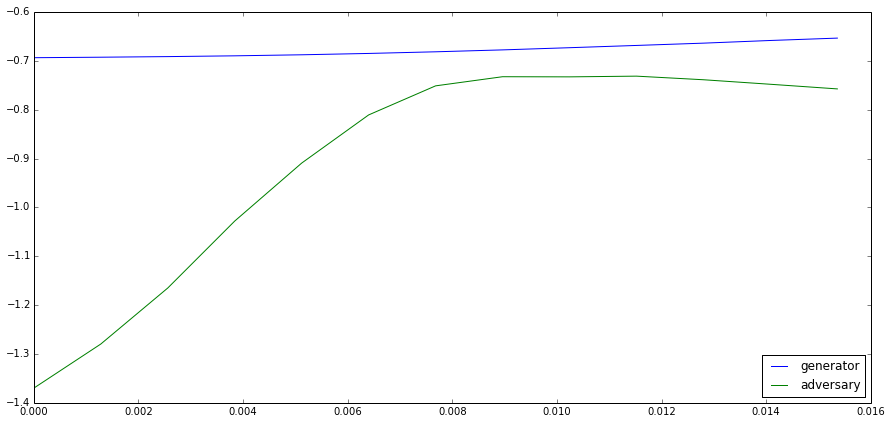

In [90]:
plt.figure(figsize=(15,7))
plt.plot(idx_graph, gen_graph, label="generator")
plt.plot(idx_graph, adv_graph, label="adversary")
plt.legend(loc="lower right")

In [87]:
?plt.legend